In [1]:
import os
import shutil
import nibabel as nib
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from lameg.invert import invert_ebb, coregister, load_source_time_series
from lameg.simulate import run_dipole_simulation
from lameg.laminar import compute_csd
from lameg.viz import plot_csd

In [2]:
# Where to put simulated data
tmp_dir='/scratch/bonaiuto/simulated_data/csd'

# Subject information for data to base simulations on
subj_id='sub-104'
ses_id='ses-01'
# Fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data','spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')
# Mesh to use for forward model
multilayer_mesh_fname = os.path.join('../test_output', subj_id, 'multilayer.11.ds.link_vector.gii')
# Number of layers in the multilayer mesh
n_layers=11
    
# Load multilayer mesh and compute the number of vertices per layer
mesh=nib.load(multilayer_mesh_fname)
verts_per_surf=int(mesh.darrays[0].data.shape[0]/n_layers)

# Data file to base simulations on
data_file=os.path.join('../test_data', 'processed', subj_id, ses_id, 'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Copy data files to tmp directory
shutil.copy(os.path.join(data_path, f'{data_base}.mat'), os.path.join(tmp_dir, f'{data_base}.mat'))
shutil.copy(os.path.join(data_path, f'{data_base}.dat'), os.path.join(tmp_dir, f'{data_base}.dat'))

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')      

In [3]:
# Invert the subject's data. This step only has to be done once - this is just to compute the forward model
# that will be used in the simulations

# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size=5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, base_fname)

# Run inversion
[_,_]=invert_ebb(multilayer_mesh_fname, base_fname, n_layers, patch_size=patch_size, 
                 n_temp_modes=n_temp_modes)

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


[0.4718776  0.45991436 0.45987025 0.45984438 0.4598113  0.45979115
 0.45976868 0.4597443  0.45981875 0.45882282]


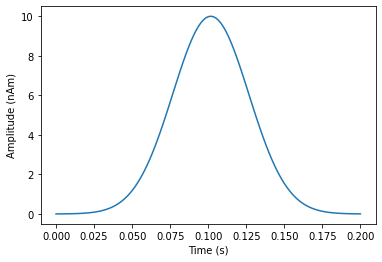

In [4]:
# Vertex to simulate activity at
sim_vertex=24588
# Strength of simulated activity (nAm)
dipole_moment=10
# Size of simulated patch of activity (mm)
sim_patch_size=5
# SNR of simulated data (dB)
SNR=-5
# Temporal width of the simulated Gaussian
signal_width=.025 # 25ms

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]
sim_signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2))
plt.plot(time,dipole_moment*sim_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

layer_verts=[l*int(verts_per_surf)+sim_vertex for l in range(n_layers)]
layer_coords=mesh.darrays[0].data[layer_verts,:]
layer_dists=np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


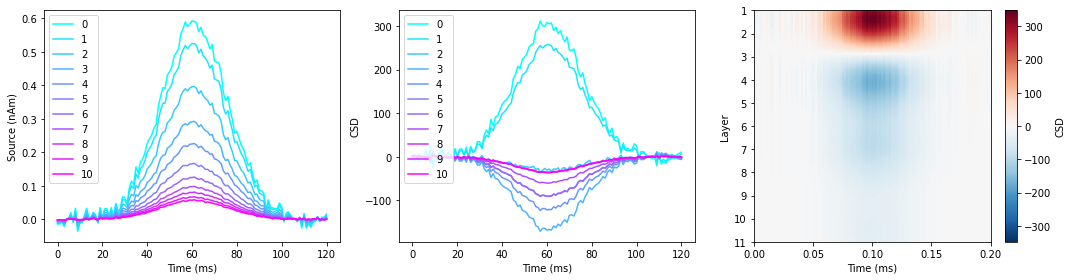

In [5]:
# Simulate at a vertex on the pial surface
pial_vertex=sim_vertex
# Orientation of the simulated dipole
pial_unit_norm=mesh.darrays[2].data[pial_vertex,:]
prefix=f'sim_{sim_vertex}_superficial.'

# Generate simulated data
pial_sim_fname=run_dipole_simulation(base_fname, prefix, pial_vertex, sim_signal, pial_unit_norm, 
                                     dipole_moment, sim_patch_size, SNR)

# Run inversion
[_,_]=invert_ebb(multilayer_mesh_fname, pial_sim_fname, n_layers, patch_size=patch_size, 
                 n_temp_modes=n_temp_modes)

# Get source time series for each layer
layer_ts=load_source_time_series(pial_sim_fname, vertices=layer_verts)
    
# Average over trials and compute CSD and smoothed CSD
mean_layer_ts=np.mean(layer_ts,axis=-1)
[csd, smooth_csd]=compute_csd(mean_layer_ts,np.mean(layer_dists),600,smoothing='cubic')

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for l in range(n_layers):
    plt.plot(mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('Source (nAm)')

plt.subplot(1,3,2)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')

ax=plt.subplot(1,3,3)
plot_csd(smooth_csd, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


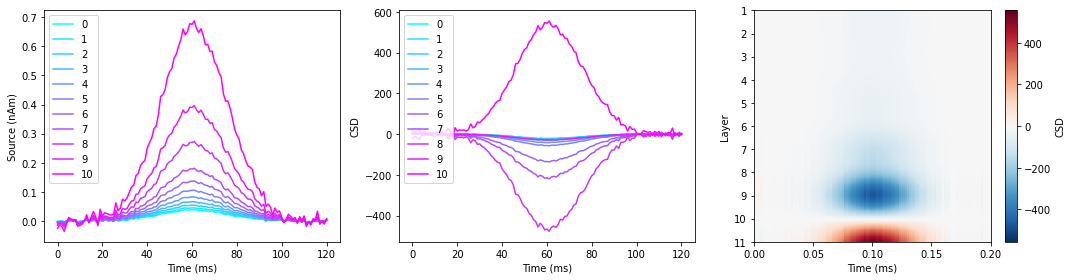

In [6]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex=(n_layers-1)*int(verts_per_surf)+sim_vertex
prefix=f'sim_{sim_vertex}_deep.'

# Generate simulated data
white_sim_fname=run_dipole_simulation(base_fname, prefix, white_vertex, sim_signal, pial_unit_norm, 
                                      dipole_moment, sim_patch_size, SNR)

# Run inversion
[_,_]=invert_ebb(multilayer_mesh_fname, white_sim_fname, n_layers, patch_size=patch_size, 
                 n_temp_modes=n_temp_modes)

# Get source time series for each layer
layer_ts=load_source_time_series(white_sim_fname, vertices=layer_verts)
    
# Average over trials and compute CSD and smoothed CSD
mean_layer_ts=np.mean(layer_ts,axis=-1)
[csd, smooth_csd]=compute_csd(mean_layer_ts,np.mean(layer_dists),600,smoothing='cubic')

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for l in range(n_layers):
    plt.plot(mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('Source (nAm)')

plt.subplot(1,3,2)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')

ax=plt.subplot(1,3,3)
plot_csd(smooth_csd, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

Simulating in layer 0
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 1
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 2
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 3
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 4
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00

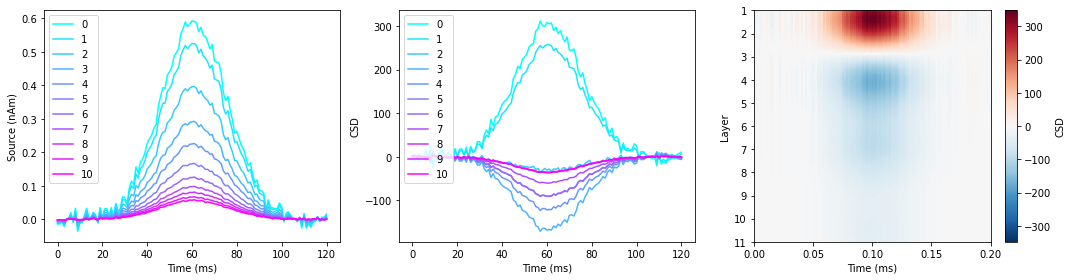

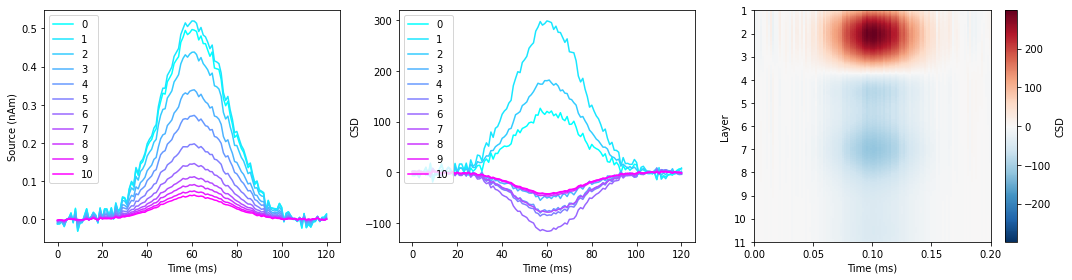

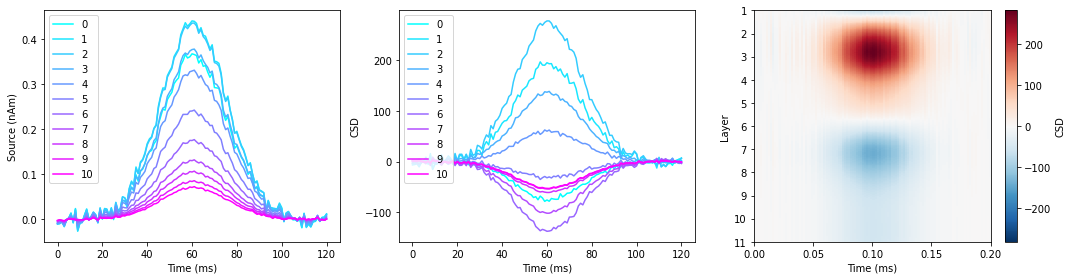

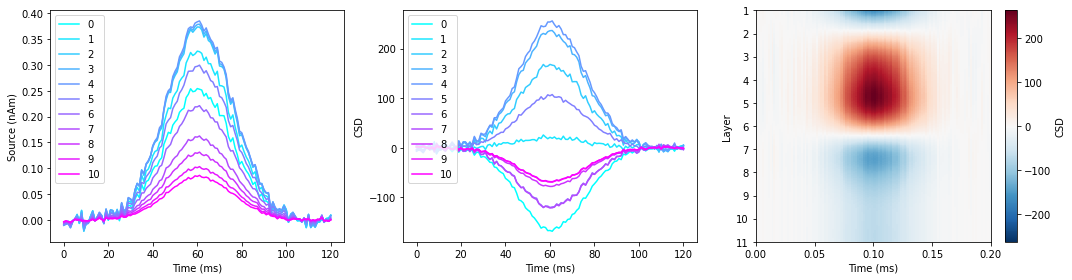

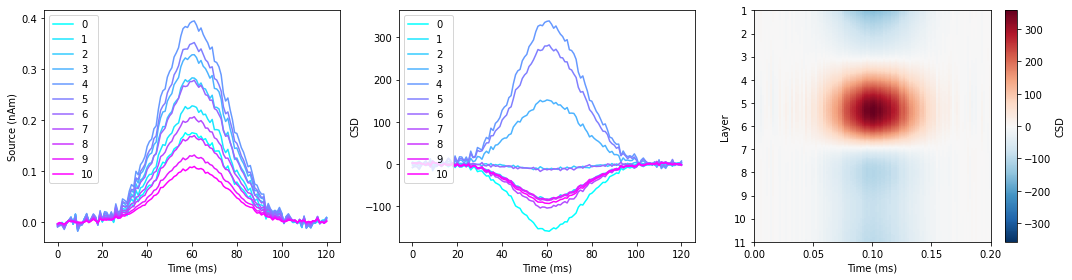

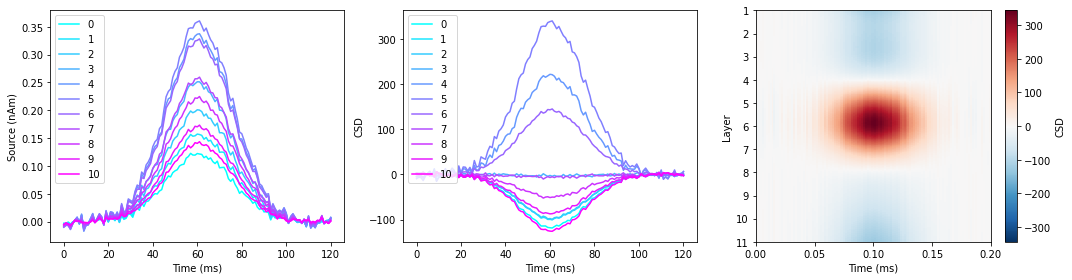

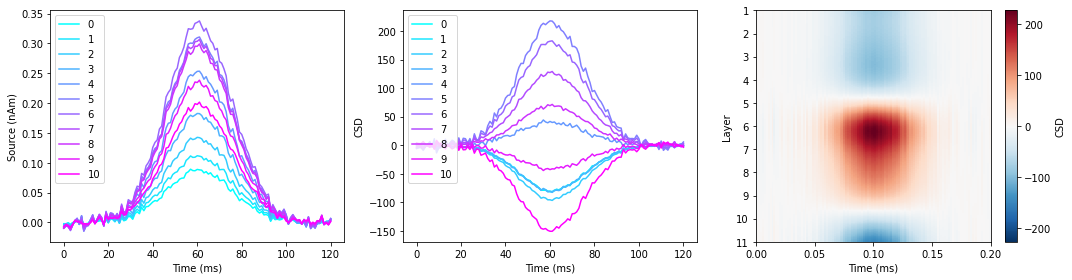

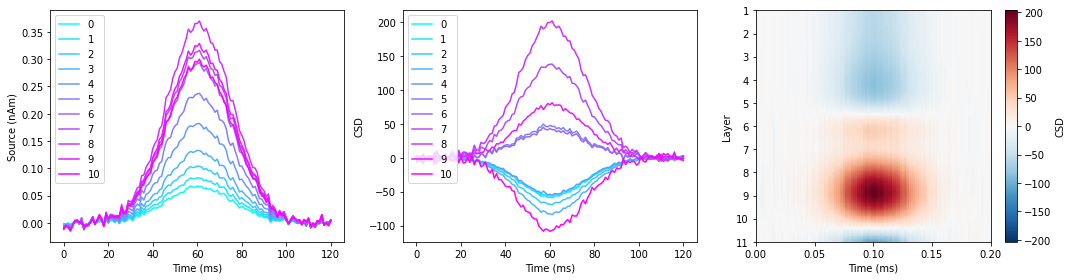

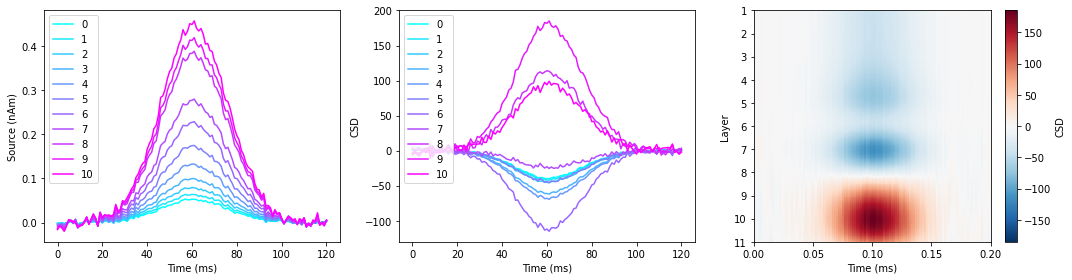

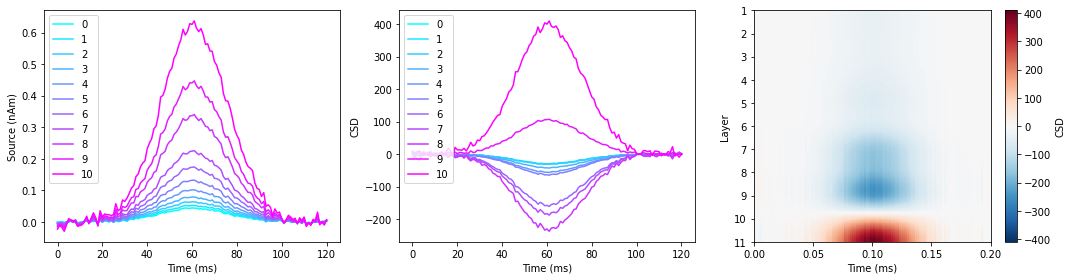

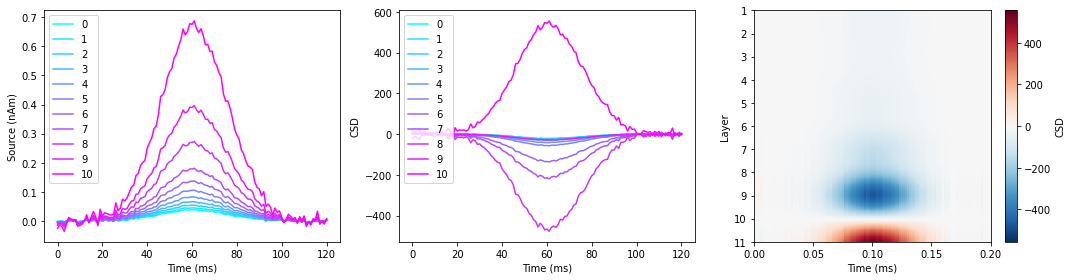

In [7]:
# Now simulate at the corresponding vertex on each layer, and for each simulation compute CSD
layer_csds=[]
for l in range(n_layers):
    print(f'Simulating in layer {l}')
    prefix=f'sim_{sim_vertex}_{l}.'
    l_vertex=l*int(verts_per_surf)+sim_vertex

    l_sim_fname=run_dipole_simulation(base_fname, prefix, l_vertex, sim_signal, pial_unit_norm, dipole_moment, 
                                      sim_patch_size, SNR, viz=False)

    [_,_]=invert_ebb(multilayer_mesh_fname, l_sim_fname, n_layers, patch_size=patch_size, 
                     n_temp_modes=n_temp_modes, viz=False)

    layer_ts=load_source_time_series(l_sim_fname, vertices=layer_verts)

    mean_layer_ts=np.mean(layer_ts,axis=-1)
    [csd, smooth_csd]=compute_csd(mean_layer_ts,np.mean(layer_dists),600,smoothing='cubic')

    col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    for l in range(n_layers):
        plt.plot(mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
    plt.legend(loc='upper left')
    plt.xlabel('Time (ms)')
    plt.ylabel('Source (nAm)')

    plt.subplot(1,3,2)
    for l in range(n_layers):
        plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
    plt.legend(loc='upper left')
    plt.xlabel('Time (ms)')
    plt.ylabel('CSD')

    ax=plt.subplot(1,3,3)
    plot_csd(smooth_csd, time, ax)
    plt.xlabel('Time (ms)')
    plt.ylabel('Layer')
    plt.tight_layout()

    layer_csds.append(smooth_csd)        

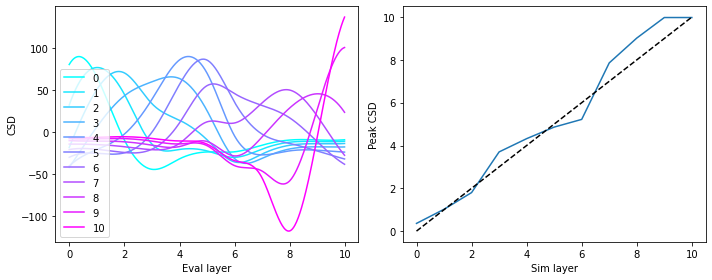

In [8]:
csd_patterns=[]
peaks=[]
for layer_csd in layer_csds:
    t_idx=np.where((time>=0.05) & (time<=0.07))[0]
    csd_pattern=np.mean(layer_csd[:,t_idx],axis=1)
    peaks.append(np.argmax(csd_pattern)/50)
    csd_patterns.append(csd_pattern)
    
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the CV error of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(np.arange(len(csd_patterns[l]))/50,csd_patterns[l], label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('CSD')

# For each simulation, find which layer model had the lowest CV error
plt.subplot(1,2,2)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Peak CSD')
plt.tight_layout()

In [10]:
deep_width=.025
superficial_width=.01
deep_signal=np.exp(-((time-zero_time)**2)/(2*deep_width**2))
superficial_signal=np.exp(-((time-zero_time)**2)/(2*superficial_width**2))

sim_pos=[white_vertex, pial_vertex]
# Orientation of each dipole
sim_ori=np.vstack([-1*pial_unit_norm, pial_unit_norm])
# Dipole momemnts
sim_dipmom=[6, 8] # nAm
# Combined signal
sim_signal=np.vstack([deep_signal, superficial_signal])
# Width of patch
sim_dipfwhm=[5, 5] # mm
    

prefix=f'sim_{sim_vertex}_burst.'
burst_sim_fname=run_dipole_simulation(base_fname, prefix, sim_pos, sim_signal, sim_ori, sim_dipmom, sim_dipfwhm,
                                      SNR)    

Text(0, 0.5, 'Amplitude (nAm)')

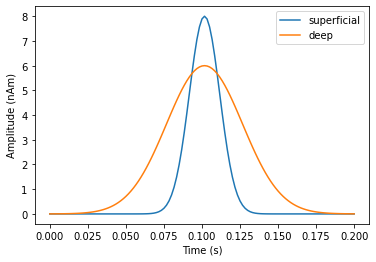

In [11]:
plt.figure()
plt.plot(time,superficial_signal*sim_dipmom[1], label='superficial')
plt.plot(time,deep_signal*sim_dipmom[0], label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [12]:
[_,_]=invert_ebb(multilayer_mesh_fname, burst_sim_fname, n_layers, patch_size=patch_size,
                 n_temp_modes=n_temp_modes, viz=False)

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


In [14]:
layer_ts=load_source_time_series(burst_sim_fname, vertices=layer_verts)
mean_layer_ts=np.mean(layer_ts,axis=-1)
[csd, smooth_csd]=compute_csd(mean_layer_ts,np.mean(layer_dists),600,smoothing='cubic')

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


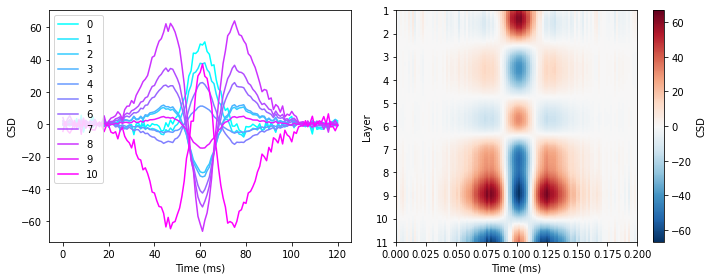

In [16]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [17]:
# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)